In [1]:
import pandas as pd
import numpy as np
import nltk 
import re
import matplotlib.pyplot as plt
import seaborn as sns
import random

from collections import Counter

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster.hierarchical import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

%matplotlib inline

In [2]:
data = pd.read_csv("emails/Emails.csv")

In [3]:
data.head()

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...
3,4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...,F-2015-04841,...,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
4,5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\nFriday, March 11,...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...


## Изучение датасета
Сразу бросается в глаза количество колонок с метаданными, которые нам не очень интересны. Также, поле RawText, пусть и содержит тексты писем, является менее полезным, чем ExtractedBodyText -- его не нужно так тщательно очищать. Тема письма, вероятно, тоже поможет при кластеризации.

Поэтому будем работать с двумя полями: Emails.ExtractedBodyText и Emails.ExtractedSubject

In [4]:
data = data[["ExtractedSubject", "ExtractedBodyText"]]
data = data.rename(columns={"ExtractedSubject": "Subject", "ExtractedBodyText": "Text"})
data = data.dropna(how='any', subset=["Text", "Subject"])
data.head()

,Subject,Text
2,Re: Chris Stevens,Thx
5,Meet The Right Wing Extremist Behind Anti-Musl...,Pis print.\n-•-...-^\nH < hrod17@clintonernail...
8,FVV: Secretary's remarks,FYI
9,more on Libya,"B6\nWednesday, September 12, 2012 6:16 PM\nFwd..."
10,AbZ and Hb3 on Libya and West Bank/Gaza,Fyi\nB6\n— —


In [5]:
plaintext = zip(data["Subject"].tolist(), data["Text"].tolist())

In [6]:
to_delete = ["b6", "b5", "--", "re:", "h:", "case no.", "doc no.", "date:", "state dept", "prom:", "sent", 
             "to:", "cc:", "fw:", "fvv:", "from:", "for:", "tel:", "fax:", "fwd:", "b1", "b2", "b3", "b4", "1.4(", 
             "#1", "1#", "release in", "u.s. department of state", "subject to agreement", 
             "ent of state", "state-", "attachment=", "january", "february", "march", "april", "may", 
             "june", "july", "august", "september", "october", "december", "http", "delivered"]

new_text = []
for text in plaintext:
    key = text[0].lower()
    for i in to_delete:
        while i in key:
            key = key.replace(i, "")
            
    if key:
        new_text.append([key])
    else:
        new_text.append([])
    
    for row in text[1].split("\n"):
        new_line = row.lower()
        for i in to_delete:
            if i in new_line:
                new_line = ""
                break
        
        if new_line:
            new_text[-1].append(new_line)
    
    new_text[-1] = " ".join(new_text[-1])

new_text[20:25]

[' wash post: hillary clinton tries to calm at i-u s iment as protesters storm embassy in yemen',
 ' quick summary of potus calls to presidents of libya and egypt pis print. fyi',
 ' condolences from pm netanyahu fyi',
 ' situation report no 1 09/14/1 (sbu) i\'m giving you credit for inspiring the "peaceful" protests.',
 'you do great work - thanks for making our heros have the homecoming they deserved.']

In [7]:
good_pattern = re.compile("[a-z0-9]")
bad_words = stopwords.words("english") + ["fyi", "pls", "ok", "thx", "yes", "no"]
good_text = []
for line in new_text:
    tokens = word_tokenize(line)
    good_tokens = [i for i in tokens if i not in bad_words and good_pattern.match(i) and i.isalnum()]
    
    if good_tokens:
        good_text.append(good_tokens)
    
good_text[20:25]

[['wash',
  'post',
  'hillary',
  'clinton',
  'tries',
  'calm',
  'iment',
  'protesters',
  'storm',
  'embassy',
  'yemen'],
 ['quick',
  'summary',
  'potus',
  'calls',
  'presidents',
  'libya',
  'egypt',
  'pis',
  'print'],
 ['condolences', 'pm', 'netanyahu'],
 ['situation',
  'report',
  '1',
  'sbu',
  'giving',
  'credit',
  'inspiring',
  'peaceful',
  'protests'],
 ['great', 'work', 'thanks', 'making', 'heros', 'homecoming', 'deserved']]

In [8]:
def find_bigrams(text, n):
    ngrams = Counter()
    for tokens in text:
        for pair in [(tokens[i], tokens[i + 1]) for i in range(len(tokens) - 1)]:
                ngrams[str(pair[0]) + " " + str(pair[1])] += 1

    return ngrams.most_common(n)
    
print("\n".join(map(str, find_bigrams(good_text, 5))))

('secretary office', 367)
('state department', 334)
('united states', 318)
('white house', 276)
('pm secretary', 216)


Кажется, топ-5 биграмм не очень информативны, поскольку в них нет новой для нас информации: мы и так знаем, что Хиллари Клинтон была US Secretary of State и сидела в Белом Доме

In [9]:
def find_collocs(text, n, freq):
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    all_words = []
    for line in text:
        for token in line:
            all_words.append(token)
    finder = BigramCollocationFinder.from_words(all_words)
    finder.apply_freq_filter(freq)
    return finder.nbest(bigram_measures.pmi, n)

find_collocs(good_text, 10, 3)

[('630pm', 'shaw'),
 ('buenos', 'aires'),
 ('dalai', 'lama'),
 ('irwin', 'redlener'),
 ('jassim', 'jabr'),
 ('kin', 'notifications'),
 ('kuan', 'yew'),
 ('noor', 'ramsey'),
 ('phd', 'purdue'),
 ('tick', 'tock')]

Коллокации уже повеселее, они указывают на места и на конкретных личностей.
 * 630 (at) shaw (campus) -- видимо, относит к выступлению перед выпускниками в школе Shaw.
 * Буэнос-Айрес, Далай Лама -- ясно-понятно.
 * Ирвин Рэдленер -- педиатр и спикер, основатель Children's Health Fund.
 * Хамад бен Джасим бен Джабер Аль Тани -- бывший премьер-министр Катара.
 * (Next of) kin notification -- "похоронка", божечки. Упоминалась в контексте скандала в Бенгази, после убийства 4 американских граждан. Ходили слухи, что миссис Клинтон знала о предстоящей атаке, но не предупредила.
 * Ли Куан Ю -- тот самый президент Сингапура.
 * Нур и Рамси -- двое похищенных приёмной матерью детей, которых отвезли в Египет, и, кажется, вернули отцу. Это было большим скандалом в 2009.
 * PhD Purdue -- степень доктора наук в Университете Пердью.
 * (Libya) Tick Tock -- самая интересная коллокация. Письмо, которое якобы доказывает причастность Хиллари к перевороту и войне в Ливии, хронология всех её участий в заседаниях НАТО. Легко гуглится, сложно пересказывается.
 
Такая простая обработка, такие любопытные результаты! Но перейдём к кластеризации.

### Поиск хорошей кластеризации
Посмотрю на 1/5 датасета, что в нем происходит, как его лучше визуализировать и как подобрать количество кластеров.
Качество определяю по графику после сжатия размерности, на глаз.

Результат представлен для бОльшей части датасета, так как весь не влезает в память, причем результаты от 2000 записей и больше получаются схожими.

In [10]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
good_text = random.sample(good_text, 3500)
sentences = [" ".join(i) for i in good_text]
X = vectorizer.fit_transform(sentences)

In [19]:
N = 6
#model = AgglomerativeClustering(n_clusters=N, affinity='euclidean')
model = KMeans(n_clusters=N)
preds = model.fit_predict(X.toarray())

### Визуализация
Мне понравились коллокации на большом тексте, буду выводить их для всех кластеров.
Ну и биграммы тоже, для большей читаемости.

In [20]:
clusters = [[] for i in range(N)]

for pos, i in list(enumerate(preds)):
    clusters[i].append(good_text[pos])

for pos, i in list(enumerate(clusters)):
    print("===== Cluster {}, len {} =====".format(pos, len(i)))
    collocs = find_collocs(i, 10, 3)
    bigrams = find_bigrams(i, 5)
    print("; ".join([j[0] + " " + j[1] for j in collocs]))
    print("---")
    print("; ".join([j[0] for j in bigrams]))

===== Cluster 0, len 2452 =====
1775 massachusetts; adoptions migrants; cingular xpress; definitive sourcing; drl definitive; hate crimes; hilda solis; noor ramsey; slipped disc; stonebridge 1101
---
secretary state; let know; assistant secretary; lona valmoro; special assistant
===== Cluster 1, len 405 =====
breeding genetics; carnegie endowment; connects labs; fertilizer irrigation; judea samaria; kin notifications; phd purdue; plant breeding; salt lake; striga weed
---
united states; 1 1; white house; tea party; 2 2
===== Cluster 2, len 392 =====
nora toiv; harry reid; kurt campbell; dennis ross; dep sec; eik pushed; fmr dep; hungarian prime; joanne laszczych; lona valmoro
---
call list; call sheet; thru ops; let know; please call
===== Cluster 3, len 78 =====
budget testimony; h hrod17; libya sid; sid pis; oscar print; pis print; huma print; print hrc; print h; print print
---
pis print; print hrc; sid pis; h hrod17; budget testimony
===== Cluster 4, len 48 =====
administers oath; 

In [21]:
N_comp = 4
svd = TruncatedSVD(n_components=4)
res = svd.fit_transform(X.toarray())

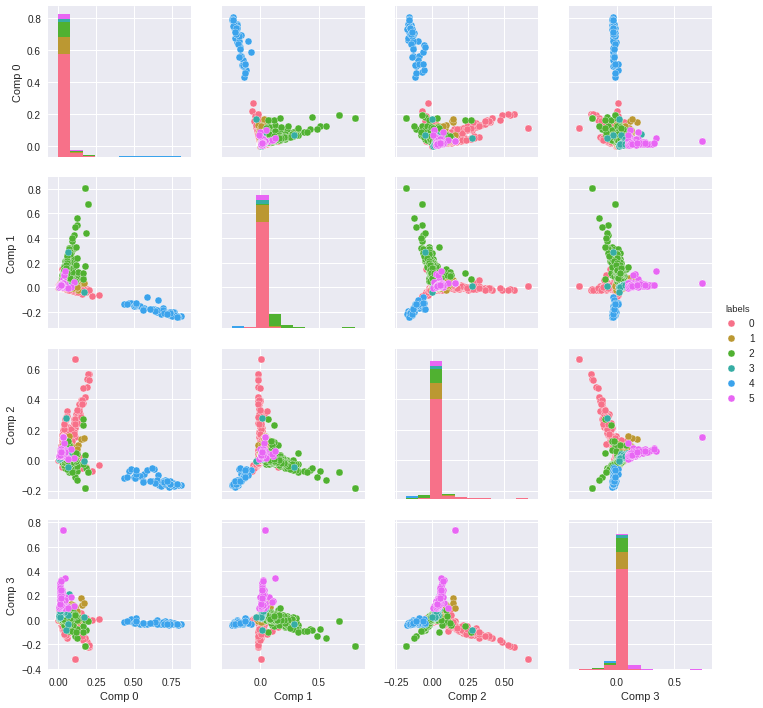

In [22]:
g = pd.DataFrame(res, columns=["Comp {}".format(i) for i in range(N_comp)])
g["labels"] = preds
sns.pairplot(g, hue="labels", palette="husl", vars=["Comp {}".format(i) for i in range(N_comp)])

### Заключение
Несмотря на то, что алгоритмам кластеризации не удалось визуально разделить графики (казалось бы, можно увидеть радиальные линии и "сердцевинки"), семантически кластеры имеют какой-то смысл: позвонить, выступить, проинформировать (update), несколько кластеров про разных политиков и общественных деятелей.


Раньше были заметны кластеры-тавтологии: ok ok, sid pls; print pls, после этого я удалила слова-паразиты и сокращения. Хорошо бы ещё исправить опечатки, но велик шанс исправить что-то полезное: имя или локацию.

Ассесорам я бы предложила назвать кластеры с учетом пары десятков биграмм и коллокаций. Опрошенные мной люди либо отказывались делать предсказания названий, либо не знали встретившихся имён и названий.